# Coursera

##   AI for Medicine Specialization

###     AI for Medical Diagnosis

####       Week 1

# Densenet

Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network
- The first layer is connected to the 3rd, 4th etc.
- The second layer is connected to the 3rd, 4th, 5th etc.

Like this:

<img src="../../imgs/densenet.png" alt="U-net Image" width="400" align="middle"/>

For a detailed explanation of Densenet, check out the source of the image above, a paper by Gao Huang et al. 2018 called [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf).

#### The classwork was developed for a the v1 version of tensorflow; I have rewritten it to accomodate the v2 version of tensorflow, and while I was at it, I reworked the whole thing to improve my understanding

#### In addition, the valid-small.csv had only one image in images-small/. So I extracted the rest using 'Pull the missing images in valid-small.ipynb'

In [29]:
import os
import pytz
import random
import sklearn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pprint import pprint
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [30]:
tf.__version__

'2.17.0'

In [31]:
# Set the seed for reproducibility
random_state=42

random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [32]:
# this accomodates Google colab and my personal Mac Book Pro

data_dir  = "../../data/nih/"

try:
  from google.colab import drive
  drive.mount('/content/drive')
  !cp -r "/content/drive/MyDrive/machine learning/Coursera Medical XRays" /content/

  data_dir  = '/content/Coursera Medical XRays/data/nih/'
  os.chdir('/content/drive/MyDrive/machine learning/Coursera Medical XRays/AI for Medical Diagnosis/Week 1')
except:
  pass

In [33]:
!pwd

/home/ec2-user/machine_learning/Coursera Medical XRays/AI for Medical Diagnosis/Week 1


# Global-use variables

In [34]:
# image-dimesions to use in the neural net
target_w, target_h = 320, 320

# number of batches to use in the neural net
batch_size         = 64

# Load and prepare the data

## (1024, 1024, 3) x-rays and length-14 arrays of 1s and 0s indicating diseases

In [35]:
image_dir = data_dir + "images-small/"

train_csv = data_dir + "train-small.csv"
valid_csv = data_dir + "valid-small.csv"
test_csv  = data_dir + "test.csv"

## Create text labels

In [36]:
train_df = pd.read_csv(train_csv)
valid_df = pd.read_csv(valid_csv)
test_df  = pd.read_csv(test_csv)

labels_text = list(train_df.drop(['Image','PatientId'], axis=1).columns)
pprint(labels_text)

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']


## Check for NaNs

In [37]:
def check_nans_in_dataframe(df):
    # Check for NaN values in each column
    nan_summary = df.isnull().sum()
    
    # Filter to only show columns that have NaN values
    nan_summary = nan_summary[nan_summary > 0].sort_values(ascending=False)
    
    # Create a DataFrame to display the result in a tabular form
    nan_report = pd.DataFrame({
        'Column': nan_summary.index,
        'Num_NaNs': nan_summary.values
    })
    
    if nan_report.empty:
        print("No NaN values found in the DataFrame.")
    else:
        display(nan_report)  # Displays the DataFrame in a Jupyter Notebook, or you can use print(nan_report)
        
    return nan_report

# Example usage with your DataFrame
# df = pd.read_csv('your_file.csv')  # Example of loading data
nan_report = check_nans_in_dataframe(train_df)
nan_report = check_nans_in_dataframe(valid_df)
nan_report = check_nans_in_dataframe(test_df)

No NaN values found in the DataFrame.
No NaN values found in the DataFrame.
No NaN values found in the DataFrame.


In [38]:
train_df.head(2)

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0


## Keep PatientId unique among train_df, valid__df and test_df

In [39]:
# Assume train_df, valid_df, and test_df all have a column 'PatientId'

print(f"df sizes before removal {train_df.shape = } {valid_df.shape = } {test_df.shape = }")

# Step 1: Remove rows from train_df where 'PatientId' exists in valid_df or test_df
train_df = train_df[~train_df['PatientId'].isin(valid_df['PatientId'])]
train_df = train_df[~train_df['PatientId'].isin(test_df['PatientId'])]

# Step 2: Remove rows from valid_df where 'PatientId' exists in test_df
valid_df = valid_df[~valid_df['PatientId'].isin(test_df['PatientId'])]

print(f"df sizes  after removal {train_df.shape = }  {valid_df.shape = } {test_df.shape = }")

# Now, train_df and valid_df should no longer contain 'PatientId' values that overlap with valid_df or test_df.

df sizes before removal train_df.shape = (1000, 16) valid_df.shape = (109, 16) test_df.shape = (420, 16)
df sizes  after removal train_df.shape = (989, 16)  valid_df.shape = (109, 16) test_df.shape = (420, 16)


## Create datasets in Numpy

In [40]:
for i in range(1):
    image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, train_df['Image'].iloc[i]))
    image = tf.keras.preprocessing.image.img_to_array(image)

image.shape

(1024, 1024, 3)

In [41]:
X_train = []

for i in range(len(train_df['Image'])):
    image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, train_df['Image'].iloc[i]), target_size=(target_w, target_h))
    image = tf.keras.preprocessing.image.img_to_array(image)
    X_train.append(image)

X_train = np.array(X_train).astype(np.float32)

y_train = train_df[labels_text].values.astype(np.int32)  # Get the multi-label output

# ----------------

X_valid = []
for i in range(len(valid_df['Image'])):
    image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, valid_df['Image'].iloc[i]), target_size=(target_w, target_h))
    image = tf.keras.preprocessing.image.img_to_array(image)
    X_valid.append(image)

X_valid = np.array(X_valid).astype(np.float32)

y_valid = valid_df[labels_text].values.astype(np.int32)  # Get the multi-label output

# ----------------

X_test = []

for i in range(len(test_df['Image'])):
    image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, train_df['Image'].iloc[i]), target_size=(target_w, target_h))
    image = tf.keras.preprocessing.image.img_to_array(image)
    X_test.append(image)

X_test = np.array(X_test).astype(np.float32)

y_test = test_df[labels_text].values.astype(np.int32)  # Get the multi-label output

print(f"{X_train.shape = } {X_valid.shape = } {X_test.shape = }")
print(f"{y_train.shape = }          {y_valid.shape = }          {y_test.shape = }")

X_train.shape = (989, 320, 320, 3) X_valid.shape = (109, 320, 320, 3) X_test.shape = (420, 320, 320, 3)
y_train.shape = (989, 14)          y_valid.shape = (109, 14)          y_test.shape = (420, 14)


# Convert to tensors

In [42]:
train_tf = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_tf = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_tf  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Cache the datasets (to avoid redundant operations in future epochs)
train_tf = train_tf.cache()
valid_tf = valid_tf.cache()
test_tf  = test_tf.cache()

# Shuffle the train dataset
train_tf = train_tf.shuffle(buffer_size=1024)  # Shuffle only the training data

# from tensorflow_utils import combine_features
# # Map the combine_features function
# train_tf = train_tf.map(lambda x, y: (combine_features(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# valid_tf = valid_tf.map(lambda x, y: (combine_features(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# test_tf  = test_tf.map(lambda x, y:  (combine_features(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Batch, prefetch for efficient processing
train_tf = train_tf.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_tf = valid_tf.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_tf  = test_tf.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
# Verify the shapes of the features and labels in the combined dataset
print("\nFor train_dataset")
for feature_batch, label_batch in train_tf.take(1):
    print(f"Combined Feature Batch Shape (batch size, width, height, layers): {feature_batch.shape}")
    print(f"Label Batch Shape            (batch size, number of classes):     {label_batch.shape}")


For train_dataset
Combined Feature Batch Shape (batch size, width, height, layers): (64, 320, 320, 3)
Label Batch Shape            (batch size, number of classes):     (64, 14)


2024-10-21 04:17:31.107914: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Data Visualization


np.min((X_train/255.0)) = 0.0
np.max((X_train/255.0)) = 1.0
X_train.shape = (989, 320, 320, 3)


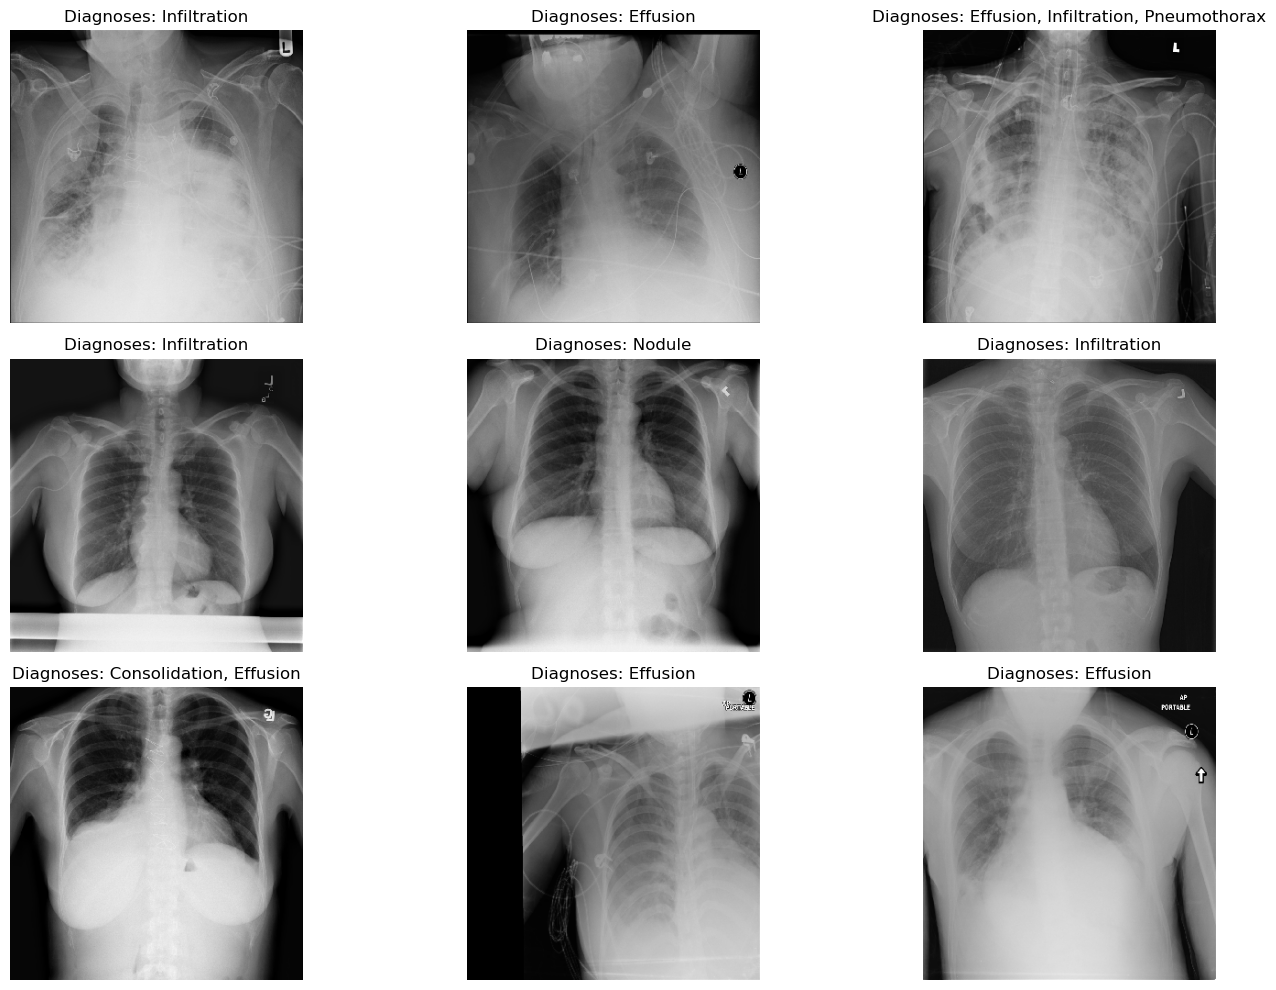

In [44]:
def shuffled_list(n):
  '''Creates a shuffled list of integers from 0 to n-1'''
  lst = list(range(n))  # Create a list from 0 to n
  random.shuffle(lst)   # Shuffle the list in place
  return lst

def display_images_with_diseases(X_train, y_train, labels_text, normalized=False):
    """
    Displays a 3x3 grid of images from `X_train` with their corresponding diagnoses (diseases).

    This function selects up to 9 images from `X_train` that have at least one associated disease (i.e., the 
    corresponding entry in `y_train` has a value of 1 for at least one label). For each selected image, the 
    corresponding diagnoses (from `labels_text`) are displayed as the title. Images are displayed in a 
    3x3 grid using Matplotlib.

    Args:
    X_train (np.array): A numpy array of training images, typically of shape (num_samples, height, width, channels).
                        The images are expected to be grayscale (single channel).
    y_train (np.array): A numpy array of binary labels with shape (num_samples, num_classes), where each element is 
                        0 or 1, indicating the absence or presence of the corresponding disease.
    labels_text (list): A list of text labels corresponding to the disease categories, with length equal to `num_classes`.
                        Each label describes a disease, such as ['Disease_1', 'Disease_2', ...].
    normalized (bool, optional): Whether the images in `X_train` are normalized (i.e., scaled to the range [0, 1]).
                                 If True, the images will be scaled back to the [0, 255] range for display.
                                 Default is False.

    Returns:
    None: The function displays a grid of images with their diagnoses using Matplotlib and does not return any value.

    Function Details:
    - The function uses a helper function `shuffled_list(n)` to shuffle the indices of the images to ensure random selection.
    - Only images with at least one positive diagnosis (i.e., at least one '1' in `y_train`) are displayed.
    - The function scales the images back to the [0, 255] range if they were normalized and converts them to `uint8` for proper display.
    - Each image is displayed along with its corresponding diagnoses in a 3x3 grid.
    - The function stops after displaying 9 images, ensuring the grid layout is maintained.

    Example Usage:
    ```python
    display_images_with_diseases(X_train, y_train, labels_text, normalized=True)
    ```

    """
    num_imgs = 0
    plt.figure(figsize=(15, 10))  # 15 units wide, 10 units tall

    for i in shuffled_list(X_train.shape[0]):
        if num_imgs >= 9:
            break

        # Find images with at least one disease (at least one '1' in the label)
        if np.sum(y_train[i]) > 0:
            num_imgs += 1

            # Scale image back to [0, 255] if it's normalized
            img = X_train[i] * 255.0 if normalized else X_train[i]

            # Convert to integer for display if necessary
            img = img.astype(np.uint8)

            # Get the diagnosis for this image
            diagnoses = [labels_text[j] for j in range(len(y_train[i])) if y_train[i][j] == 1]
            title_text = f"Diagnoses: {', '.join(diagnoses)}"

            plt.subplot(3, 3, num_imgs)  # Change to num_imgs to keep it within 1-9
            plt.imshow(img, cmap='gray')  # Assuming grayscale X-ray images
            plt.title(title_text)
            plt.axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# For normalized images in the range [0, 1]
print(f"\n{np.min((X_train/255.0)) = }\n{np.max((X_train/255.0)) = }")
print(f"{X_train.shape = }")
display_images_with_diseases(X_train / 255.0, y_train, labels_text, normalized=True)

# Build a DenseNet121 with Keras's Functional API

In [45]:
# -------------------------------------------------------------------------
inputs = tf.keras.layers.Input(shape=(target_h, target_w, 3))

x = tf.keras.layers.RandomBrightness(0.1)(inputs)
x = tf.keras.layers.RandomContrast(0.1)(x)

# Resize and normalize pixel values
x = tf.keras.layers.Resizing(target_h, target_w)(x)

# -------------------------------------------------------------------------

# Calculate the mean and std for the entire dataset
mean = np.mean(X_train, axis=(0, 1, 2))   # Mean over height, width, and all samples
std  = np.std(X_train,  axis=(0, 1, 2))   # Standard deviation over height, width, and all samples

def custom_densenet_preprocessing(input_tensor):
    '''
    tf.keras.applications.densenet.preprocess_input
    is specific to imagenet
       
    this function creates preprocessing specific to our training set of xrays
    '''
    return (input_tensor - mean) / std

x = tf.keras.layers.Lambda(custom_densenet_preprocessing)(x)

# -------------------------------------------------------------------------

base_model = tf.keras.applications.DenseNet121(weights='../../models/nih/densenet.hdf5', include_top=False)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreezing the last layers of the base model makes validation divergence worse

x = base_model(x)

# -------------------------------------------------------------------------

x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Flatten makes things worse

x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.2)(x)

# -------------------------------------------------------------------------

# Output layer
outputs = tf.keras.layers.Dense(14, activation='sigmoid')((x))

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [46]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_1             │ (None, 320, 320, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 320, 320, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 10, 10, 1024)   │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,105,646 (27.11 MB)

 Trainable params: 68,142 (266.18 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

# Calculate Class Weights and Loss Functions

Calculate the two terms that make up the loss function.  Notice that you are working with more than one class (represented by columns).  In this case, there are two classes.

Start by calculating the loss for class `0`.

$$ loss^{(i)} = loss_{pos}^{(i)} + los_{neg}^{(i)} $$

$$loss_{pos}^{(i)} = -1 \times weight_{pos}^{(i)} \times y^{(i)} \times log(\hat{y}^{(i)})$$

$$loss_{neg}^{(i)} = -1 \times weight_{neg}^{(i)} \times (1- y^{(i)}) \times log(1 - \hat{y}^{(i)})$$

In [47]:
def f1_score(y_true, y_pred):
    """
    Computes the F1 score, the harmonic mean of precision and recall, for multi-class or multi-label classification.

    The F1 score is calculated as:
    F1 = 2 * (precision * recall) / (precision + recall)
    
    This function supports both multi-class and multi-label tasks. It first casts the true labels and predicted 
    labels to `float32`, then applies a threshold of 0.5 to the predicted probabilities to convert them into binary 
    labels (0 or 1). It calculates true positives (TP), false positives (FP), and false negatives (FN) for each class 
    and computes the precision and recall. The F1 score is the harmonic mean of precision and recall, and this function 
    returns the average F1 score across all classes.

    Args:
    y_true (tf.Tensor): Ground truth values. Tensor of shape (batch_size, num_classes) containing binary labels.
    y_pred (tf.Tensor): Predicted values. Tensor of shape (batch_size, num_classes) containing predicted probabilities.

    Returns:
    tf.Tensor: The mean F1 score across all classes.

    Notes:
    - The function uses Keras backend (K) to calculate operations like sum and mean.
    - A small epsilon value (K.epsilon()) is added to avoid division by zero.
    - If precision + recall is zero for any class (no predictions for that class), the F1 score for that class is set to 0 
      to prevent NaN values.
    """
    # Cast y_true to float32 to match y_pred
    y_true = tf.cast(y_true, tf.float32)
    
    # Convert predictions to binary by thresholding at 0.5
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    # Calculate true positives, false positives, false negatives
    tp = K.sum(K.cast(y_true * y_pred, 'float32'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'), axis=0)
    
    # Calculate precision and recall with zero division check
    precision = tp / (tp + fp + K.epsilon())
    recall    = tp / (tp + fn + K.epsilon())
    
    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    # Handle cases where precision + recall == 0 (no predictions for this class)
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    
    # Return mean F1 score across all labels
    return K.mean(f1)

In [48]:
def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for binary or multi-label classification tasks.

    Focal Loss is designed to address the class imbalance problem by down-weighting easy examples and focusing more 
    on hard misclassified examples. The loss function is modified with the scaling factor (1 - p_t)^gamma to reduce 
    the contribution of well-classified examples and put more focus on hard misclassified examples.

    The formula for Focal Loss is:
    FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)

    Where:
    - p_t is the model's estimated probability for the true class.
    - alpha_t is the weighting factor that balances the importance of positive/negative classes.
    - gamma is a focusing parameter that reduces the loss contribution from easy examples and increases the importance of misclassified examples.

    Args:
    gamma (float, optional): Focusing parameter. Default value is 2.0.
    alpha (float, optional): Balancing factor for positive/negative classes. Default value is 0.25.

    Returns:
    function: A function that computes the focal loss between `y_true` and `y_pred`.

    The returned function `focal_loss_fixed` takes two arguments:
    - y_true (tf.Tensor): Ground truth values. Tensor of shape (batch_size, num_classes) containing binary labels.
    - y_pred (tf.Tensor): Predicted values. Tensor of shape (batch_size, num_classes) containing predicted probabilities.

    Returns:
    tf.Tensor: The mean focal loss across all samples in the batch.

    Notes:
    - The loss is computed using the predicted probabilities, which are clipped to avoid log(0).
    - Alpha is used to assign different weights to positive and negative classes to deal with class imbalance.
    - Gamma is used to focus more on hard examples by down-weighting easy ones.

    Example Usage:
    ```python
    model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])
    ```

    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()  # Small value to avoid log(0)
        
        # Clip predictions to ensure they are within the range [epsilon, 1-epsilon]
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        # Cast y_true to float32 to ensure compatibility with y_pred
        y_true = tf.cast(y_true, tf.float32)
        
        # Compute alpha_t: balance factor for positive and negative classes
        alpha_t = y_true * alpha + (tf.keras.backend.ones_like(y_true) - y_true) * (1 - alpha)
        
        # Compute p_t: the predicted probability for the true class
        p_t = y_true * y_pred + (tf.keras.backend.ones_like(y_true) - y_true) * (1 - y_pred)
        
        # Compute focal loss
        fl = - alpha_t * tf.keras.backend.pow((tf.keras.backend.ones_like(y_true) - p_t), gamma) * tf.keras.backend.log(p_t)
        
        # Return the mean focal loss across all samples
        return tf.keras.backend.mean(fl)
    
    return focal_loss_fixed

In [49]:
"""
This section calculates class weights for each label, computes sample weights, and sets up a TensorFlow dataset
to be used in the `model.fit()` function with weighted binary cross-entropy loss.

Steps:
1. **Class Weights Calculation**:
    - Class weights are computed for each label (0 to 13) using `sklearn.utils.class_weight.compute_class_weight`.
    - These weights are designed to handle class imbalance by giving higher weights to underrepresented classes (where `y=1`).
    - For each label:
      - The first value in the tuple corresponds to the weight for the negative class (`y=0`).
      - The second value corresponds to the weight for the positive class (`y=1`).

2. **Class Weights Representation**:
    - Class weights are converted to a human-readable format using a pandas DataFrame for easy inspection and verification.
    - The `weighted_binary_crossentropy_weights` DataFrame contains the weights for each label in a two-column format (`negative`, `positive`).

3. **Sample Weights Calculation**:
    - Sample weights are calculated for each sample in the training data (`y_train`).
    - The sample weights for each label are based on the class weights. Samples with `y=1` for a label are given the positive class weight, 
      while those with `y=0` are given the negative class weight.
    - After calculating the sample weights for each label, the weights are averaged across all labels to create a single weight for each sample.

4. **Prepare TensorFlow Dataset for Training**:
    - The training data (`X_train`, `y_train`) and the computed sample weights are converted into a TensorFlow dataset.
    - The dataset is cached for performance optimization, shuffled to introduce randomness during training, batched, and prefetched to optimize data loading.

Key Variables:
- `class_weights`: A dictionary containing weights for each label (0 to 13), with the negative and positive class weights.
- `class_weights_with_labels`: A dictionary mapping human-readable label names to their corresponding class weights.
- `weighted_binary_crossentropy_weights`: A pandas DataFrame representing class weights in a two-column format (`negative`, `positive`).
- `sample_weights`: A numpy array of sample weights, where each sample is assigned a weight based on the class imbalance across labels.
- `train_tf_with_weights`: A TensorFlow dataset that combines the training data (`X_train`, `y_train`) and the calculated sample weights.
"""

# Assuming y_train is your training label data with shape (samples, 14)
class_weights = {}

# Calculate class weights for each class (0 to 13)
for i in range(14):
    class_weights[i] = sklearn.utils.class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train[:, i]),
        y=y_train[:, i]
    )

# First value corresponds to the weight for class 0 (negative class, indicating absence of the label).
# Second value corresponds to the weight for class 1 (positive class, indicating presence of the label)

class_weights_with_labels            = {labels_text[key]: value for key, value in class_weights.items()}
weighted_binary_crossentropy_weights = pd.DataFrame(class_weights_with_labels, index=['negative', 'positive']).T

# Sample weights calculation (for each sample, based on the class weights)
# shape of y_train: (num_samples, 14)
sample_weights = np.ones_like(y_train, dtype=np.float32)

for i in range(14):
    sample_weights[:, i] = np.where(y_train[:, i] == 1, class_weights[i][1], class_weights[i][0])

# Flatten sample weights
sample_weights = np.mean(sample_weights, axis=1)

# Convert your training data and weights into a TensorFlow dataset to be used in model.fit
train_tf_with_weights = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weights))

train_tf_with_weights = train_tf_with_weights.cache()
train_tf_with_weights = train_tf_with_weights.shuffle(buffer_size=1024)  
train_tf_with_weights = train_tf_with_weights.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [50]:
def weighted_binary_crossentropy(class_weights):
    """
    Custom binary cross-entropy loss function with class-specific weights for multi-label classification tasks.

    This function modifies the standard binary cross-entropy loss by applying separate weights to the loss 
    for each class (label). The class weights are provided as a dictionary or list of weights for both 
    the positive (1) and negative (0) classes. The goal is to handle class imbalance by assigning higher 
    importance to underrepresented classes.

    The binary cross-entropy for each class is modified as:
    Loss = - (weight_for_0 * (1 - y_true) * log(1 - y_pred) + weight_for_1 * y_true * log(y_pred))

    Args:
    class_weights (list or dict): A list of tuples or dictionary, where each entry contains the weight 
                                  for class 0 (negative) and class 1 (positive) for each label. 
                                  Example format: [(w_0, w_1), (w_0, w_1), ...]

    Returns:
    function: A custom loss function that can be used in Keras model compilation.

    The returned function `loss` takes two arguments:
    - y_true (tf.Tensor): Ground truth values. Tensor of shape (batch_size, num_classes) containing binary labels.
    - y_pred (tf.Tensor): Predicted values. Tensor of shape (batch_size, num_classes) containing predicted probabilities.

    Returns:
    tf.Tensor: The mean weighted binary cross-entropy loss across all labels.

    Notes:
    - The loss is computed separately for each class (label), and the class-specific weights are applied 
      to balance the contribution of positive and negative examples for each class.
    - A small epsilon value (K.epsilon()) is added to the logarithmic terms to prevent numerical instability.

    Example Usage:
    ```python
    class_weights = [(0.7, 2.0), (0.5, 1.5), ...]  # List of weights for each class
    model.compile(optimizer='adam', loss=weighted_binary_crossentropy(class_weights), metrics=['accuracy'])
    ```

    """
    # Custom binary cross-entropy loss with class weights
    def loss(y_true, y_pred):
        # Initialize total loss
        loss = 0
        # For each label (disease), apply class-specific weights
        for i in range(len(class_weights)):
            weight_for_0 = class_weights[i][0]
            weight_for_1 = class_weights[i][1]
            
            # Compute the weighted binary cross-entropy for label i
            loss += -tf.reduce_mean(
                weight_for_0 * (1 - y_true[:, i]) * tf.math.log(1 - y_pred[:, i] + K.epsilon()) +
                weight_for_1 *      y_true[:, i]  * tf.math.log(    y_pred[:, i] + K.epsilon())
            )
        
        # Average the loss across all labels
        return loss / len(class_weights)
    
    return loss

In [51]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies =   np.sum(labels/N ,axis=0)
    negative_frequencies = 1-np.sum(labels/N ,axis=0)

    return positive_frequencies, negative_frequencies

freq_pos, freq_neg = compute_class_freqs(train_df.loc[:,labels_text])

pos_weights = freq_neg
neg_weights = freq_pos

# for the purpose of graphing the 0/1 contribution of each class
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

get_weighted_loss_weights = pd.DataFrame({'neg_weights': neg_weights, 'pos_weights': pos_weights})

def get_weighted_loss(pos_weights, neg_weights, epsilon=K.epsilon()):
    """
    Create a custom weighted loss function.

    -----------------------------------------------
    This is the loss function used in the classwork
    -----------------------------------------------

    Args:
    - pos_weights: Weight for positive samples.
    - neg_weights: Weight for negative samples.

    Returns:
    - A weighted loss function.
    """
    def weighted_loss(y_true, y_pred):
        # Calculate the proportion of positive and negative samples in the batch
        # Use TensorFlow operations instead of NumPy operations
        
        # initialize loss to zero
        loss = 0.0

        # Calculate positive and negative weights
#         w_p = np.sum(y_true == 0, axis=0) / y_true.shape[0]
#         w_n = np.sum(y_true == 1, axis=0) / y_true.shape[0]

        # Convert to keras-speak
        import tensorflow.keras.backend as K

        w_p = K.sum(K.cast(K.equal(y_true, 0), 'float32'), axis=0) / K.cast(K.shape(y_true)[0], 'float32')
        w_n = K.sum(K.cast(K.equal(y_true, 1), 'float32'), axis=0) / K.cast(K.shape(y_true)[0], 'float32')
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            
            pos = -1 * w_p *      y_true  * tf.keras.backend.log(     y_pred + epsilon)
            
            neg = -1 * w_n * (1 - y_true) * tf.keras.backend.log((1 - y_pred + epsilon))
            
            loss += pos + neg
            
        return tf.keras.backend.mean(loss)
            
    
    return weighted_loss


### combine the weights and develop ratios for comparison

It looks like the weights are essentially the same, differing in scale

In [52]:
combined_weights_df = pd.concat(
    [weighted_binary_crossentropy_weights, get_weighted_loss_weights],
    axis=1,
    keys=['weighted_binary_crossentropy_weights (scikit-learn)', 'get_weighted_loss_weights']
)

# Now, calculate 'pos ratio' and 'neg ratio'
combined_weights_df['get_weighted_loss_weights', 'pos ratio'] = (
    combined_weights_df['get_weighted_loss_weights', 'pos_weights'] /
    combined_weights_df['weighted_binary_crossentropy_weights (scikit-learn)', 'positive']
)

combined_weights_df['get_weighted_loss_weights', 'neg ratio'] = (
    combined_weights_df['get_weighted_loss_weights', 'neg_weights'] /
    combined_weights_df['weighted_binary_crossentropy_weights (scikit-learn)', 'negative']
)

# Show the combined DataFrame with the 'super' columns
display(combined_weights_df)

weighted_binary_crossentropy_weights (scikit-learn)  \
                                                              negative   
Atelectasis                                                  0.558757    
Cardiomegaly                                                 0.510320    
Consolidation                                                0.517259    
Edema                                                        0.508222    
Effusion                                                     0.572338    
Emphysema                                                    0.506660    
Fibrosis                                                     0.507179    
Hernia                                                       0.501013    
Infiltration                                                 0.606748    
Mass                                                         0.523280    
Nodule                                                       0.528877    
Pleural_Thickening                                           0.510847    
Pneumonia                                                    0.505107    
Pneumothorax                                                 0.519433    

                               get_weighted_loss_weights              \
                      positive               neg_weights pos_weights   
Atelectasis           4.754808                  0.105157    0.894843   
Cardiomegaly         24.725000                  0.020222    0.979778   
Consolidation        14.984848                  0.033367    0.966633   
Edema                30.906250                  0.016178    0.983822   
Effusion              3.956000                  0.126390    0.873610   
Emphysema            38.038462                  0.013145    0.986855   
Fibrosis             35.321429                  0.014156    0.985844   
Hernia              247.250000                  0.002022    0.997978   
Infiltration          2.841954                  0.175935    0.824065   
Mass                 11.238636                  0.044489    0.955511   
Nodule                9.157407                  0.054601    0.945399   
Pleural_Thickening   23.547619                  0.021234    0.978766   
Pneumonia            49.450000                  0.010111    0.989889   
Pneumothorax         13.364865                  0.037412    0.962588   

                                        
                   pos ratio neg ratio  
Atelectasis         0.188198  0.188198  
Cardiomegaly        0.039627  0.039627  
Consolidation       0.064507  0.064507  
Edema               0.031832  0.031832  
Effusion            0.220832  0.220832  
Emphysema           0.025944  0.025944  
Fibrosis            0.027911  0.027911  
Hernia              0.004036  0.004036  
Infiltration        0.289964  0.289964  
Mass                0.085020  0.085020  
Nodule              0.103239  0.103239  
Pleural_Thickening  0.041565  0.041565  
Pneumonia           0.020018  0.020018  
Pneumothorax        0.072024  0.072024

## Prior to assigning class weights

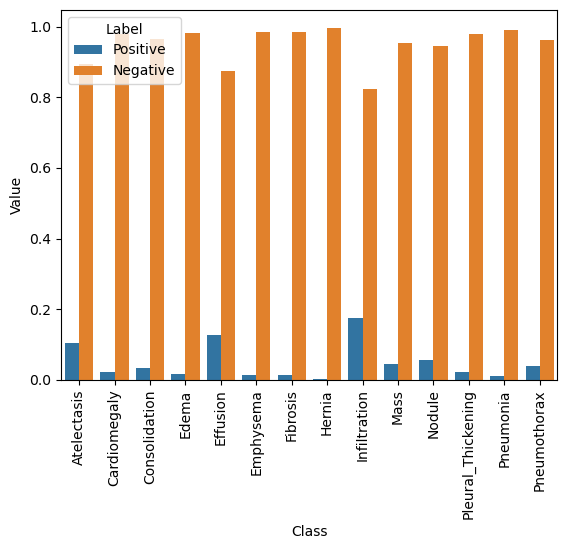

In [53]:
data = pd.DataFrame({"Class": labels_text, "Label": "Positive", "Value": freq_pos})
data = pd.concat([data, pd.DataFrame([{"Class": labels_text[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

## Following assigning class weights

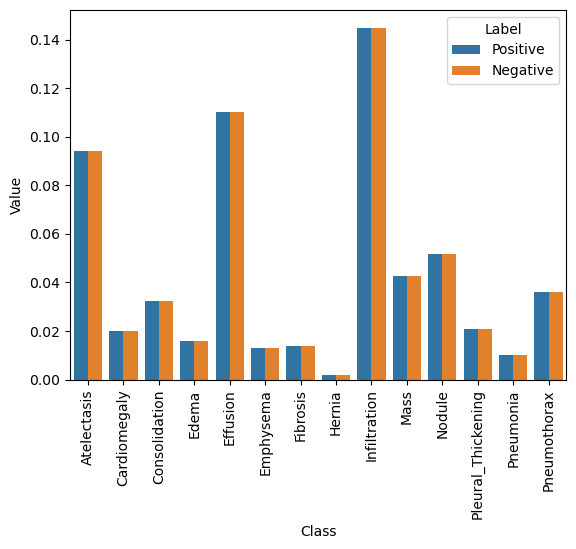

In [54]:
data = pd.DataFrame({"Class": labels_text, "Label": "Positive", "Value": pos_contribution})
# data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}
#                         for l,v in enumerate(neg_contribution)], ignore_index=True)
new_rows = pd.DataFrame([{"Class": labels_text[l], "Label": "Negative", "Value": v}
                         for l, v in enumerate(neg_contribution)])
data = pd.concat([data, new_rows], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

# Compile and fit the model

In [55]:
%%time

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              # loss=focal_loss(),
              # loss='binary_crossentropy',
              loss=get_weighted_loss(pos_weights, neg_weights),
              # loss=weighted_binary_crossentropy(class_weights),
              metrics=['auc', 'Precision', 'Recall'])

# -----------------------------------------------------------------------------------------------------

early_stopping = tf.keras.callbacks.EarlyStopping(
    verbose=1,
    monitor='val_loss',
    patience=15,
    mode='min',
    restore_best_weights=True)

# When fitting the model with PrintEveryNEpoch use verbose=0
from tensorflow_utils import PrintEveryNEpoch
periodic_messages = PrintEveryNEpoch(n=25, timezone_str='US/Mountain')


history = model.fit(
    
    #train_tf,         
    train_tf_with_weights, 
    
    verbose=0,
    epochs=50000,
    batch_size=batch_size,
    validation_data=valid_tf,
    callbacks=[early_stopping, periodic_messages])

I0000 00:00:1729484269.371829   27173 service.cc:146] XLA service 0x7fd9bc48e450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729484269.371861   27173 service.cc:154]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-10-21 04:17:49.637815: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-21 04:17:51.485014: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-21 04:17:52.611941: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10301', 140 bytes spill stores, 140 bytes spill loads

I0000 00:00:1729484291.589061   27173 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-10-21 04:18:1


Epoch 1 (2024-10-20 22:18:52): 
Precision = 0.0470, Recall = 0.5742, auc = 0.5111, loss = 1.0714, val_Precision = 0.0481, val_Recall = 0.5432, val_auc = 0.4664, val_loss = 1.1093

Epoch 25 (2024-10-20 22:19:57): 
Precision = 0.0533, Recall = 0.6057, auc = 0.5340, loss = 0.9821, val_Precision = 0.0526, val_Recall = 0.5185, val_auc = 0.4723, val_loss = 1.0646

Epoch 50 (2024-10-20 22:21:05): 
Precision = 0.0535, Recall = 0.5832, auc = 0.5515, loss = 0.9765, val_Precision = 0.0417, val_Recall = 0.3827, val_auc = 0.4500, val_loss = 1.0553

Epoch 75 (2024-10-20 22:22:16): 
Precision = 0.0577, Recall = 0.6102, auc = 0.5838, loss = 0.9541, val_Precision = 0.0481, val_Recall = 0.4198, val_auc = 0.4693, val_loss = 1.0452

Epoch 100 (2024-10-20 22:23:25): 
Precision = 0.0606, Recall = 0.6162, auc = 0.5901, loss = 0.9458, val_Precision = 0.0444, val_Recall = 0.3704, val_auc = 0.4749, val_loss = 1.0358

Epoch 125 (2024-10-20 22:24:34): 
Precision = 0.0641, Recall = 0.6402, auc = 0.6186, loss = 0.

# Print Loss Curves

	•	Recall (also known as sensitivity or true positive rate) is the percentage of all __actual__ positives in the dataset that were correctly identified by the model. 

	•	Precision is the percentage of the positive predictions made by the model that were actually correct. It measures how many of the predicted positives were true positives.

In [56]:
history.history.keys()

dict_keys(['Precision', 'Recall', 'auc', 'loss', 'val_Precision', 'val_Recall', 'val_auc', 'val_loss'])

In [57]:
losses_list=['loss', 'get_weighted_loss', 'auc']

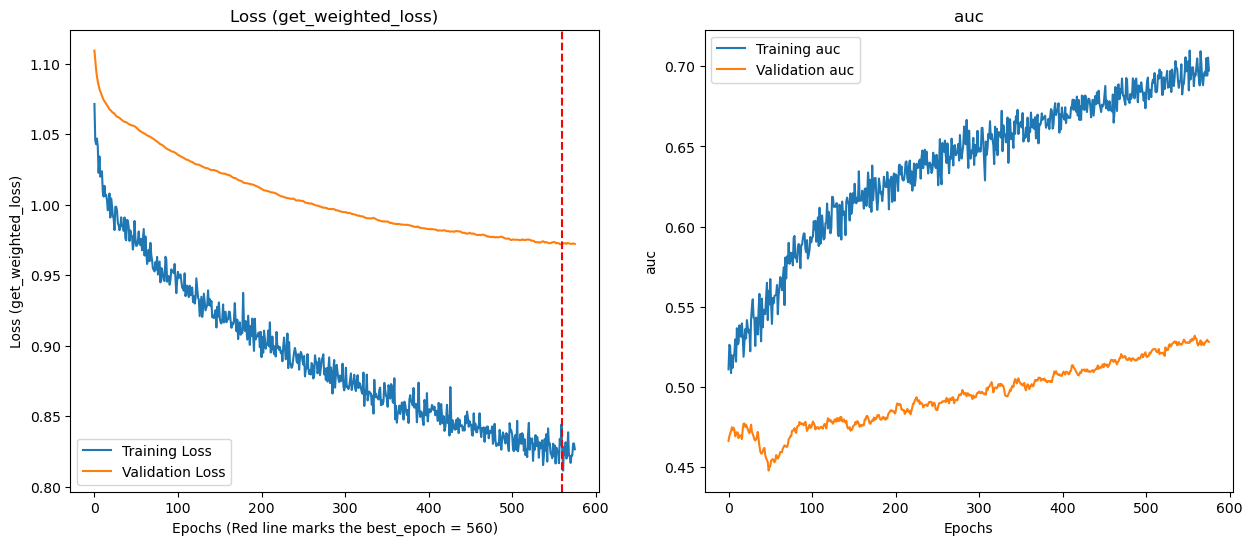

In [58]:
from tensorflow_utils import loss_curves

loss_curves(history, start_after=0, losses=losses_list, best_epoch=early_stopping.best_epoch)

# Test set evaluation

In [59]:
model_eval = model.evaluate(test_tf)

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - Precision: 0.1402 - Recall: 0.4018 - auc: 0.5139 - loss: 1.7751

2024-10-21 04:45:13.019872: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3660', 16 bytes spill stores, 16 bytes spill loads

2024-10-21 04:45:13.061954: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3660', 172 bytes spill stores, 172 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - Precision: 0.1369 - Recall: 0.3963 - auc: 0.5089 - loss: 1.7896 


In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Get the predicted probabilities from the model
y_pred_probs = model.predict(X_test)

for y_pred_thresh_gt in [0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35, 0.4, 0.5, 0.6, 0.7,0.8]:
    
    # Apply the threshold to the predictions
    y_pred_threshold = tf.cast(y_pred_probs > y_pred_thresh_gt, tf.float32)
    
    # Convert y_pred_threshold to NumPy if needed for evaluation (depending on your workflow)
    y_pred_threshold = y_pred_threshold.numpy()
    
    # Assuming you have true labels for X_test in 'y_test'
    # Use zero_division to handle cases where no positive predictions are made
    precision = precision_score(y_test, y_pred_threshold, average='macro', zero_division=0)
    recall    = recall_score(y_test, y_pred_threshold, average='macro', zero_division=0)
    f1        = f1_score(y_test, y_pred_threshold, average='macro', zero_division=0)
    auc       = roc_auc_score(y_test, y_pred_threshold, average='macro')
    
    print(f"y_pred_threshold > {y_pred_thresh_gt:>5} Precision: {precision:.04f} - Recall: {recall:.04f}, ROC AUC Score: {auc:.04f}, F1 Score: {f1:.04f}")

2024-10-21 04:45:29.980389: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3372', 140 bytes spill stores, 140 bytes spill loads



14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 787ms/step
y_pred_threshold > 0.025 Precision: 0.1308 - Recall: 1.0000, ROC AUC Score: 0.5000, F1 Score: 0.2312
y_pred_threshold >  0.05 Precision: 0.1308 - Recall: 1.0000, ROC AUC Score: 0.5000, F1 Score: 0.2312
y_pred_threshold >   0.1 Precision: 0.1308 - Recall: 1.0000, ROC AUC Score: 0.5000, F1 Score: 0.2312
y_pred_threshold >  0.15 Precision: 0.1308 - Recall: 1.0000, ROC AUC Score: 0.5000, F1 Score: 0.2312
y_pred_threshold >   0.2 Precision: 0.1307 - Recall: 0.9987, ROC AUC Score: 0.4998, F1 Score: 0.2311
y_pred_threshold >  0.25 Precision: 0.1311 - Recall: 0.9914, ROC AUC Score: 0.5014, F1 Score: 0.2314
y_pred_threshold >   0.3 Precision: 0.1314 - Recall: 0.9571, ROC AUC Score: 0.5021, F1 Score: 0.2307
y_pred_threshold >  0.35 Precision: 0.1325 - Recall: 0.8770, ROC AUC Score: 0.5046, F1 Score: 0.2292
y_pred_threshold >   0.4 Precision: 0.1281 - Recall: 0.7275, ROC AUC Score: 0.4912, F1 Score: 0.2155
y_pred_threshold >   0.5 Precision: 0.1311 - Reca

### decide which threshold to use

In [61]:
y_pred_thresh_gt = 0.50
y_pred_threshold = tf.cast(y_pred_probs > y_pred_thresh_gt, tf.float32)
y_pred_threshold = y_pred_threshold.numpy()

### confusion matrixes

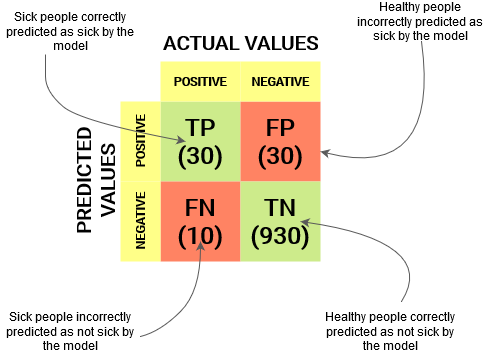

Confusion Matrix for each label:

Confusion matrix for Atelectasis:
[[230 130]
 [ 36  24]]


Confusion matrix for Cardiomegaly:
[[ 78 292]
 [  7  43]]


Confusion matrix for Consolidation:
[[268  99]
 [ 38  15]]


Confusion matrix for Edema:
[[234 136]
 [ 37  13]]


Confusion matrix for Effusion:
[[235 132]
 [ 42  11]]


Confusion matrix for Emphysema:
[[336  28]
 [ 52   4]]


Confusion matrix for Fibrosis:
[[277  82]
 [ 47  14]]


Confusion matrix for Hernia:
[[ 86 284]
 [ 14  36]]


Confusion matrix for Infiltration:
[[249 112]
 [ 40  19]]


Confusion matrix for Mass:
[[311  49]
 [ 50  10]]


Confusion matrix for Nodule:
[[254 112]
 [ 34  20]]


Confusion matrix for Pleural_Thickening:
[[ 24 338]
 [ 10  48]]


Confusion matrix for Pneumonia:
[[280  90]
 [ 37  13]]


Confusion matrix for Pneumothorax:
[[240 125]
 [ 32  23]]




In [62]:
from IPython.display import Image
from IPython.display import display

# Path to the image file
img_path = "../../imgs/Example-Confusion-matrix.png"

# Display the image
display(Image(filename=img_path))

from sklearn.metrics import multilabel_confusion_matrix

# Calculate confusion matrix for each label
conf_matrix = multilabel_confusion_matrix(y_test, y_pred_threshold)

# Print the confusion matrix for each label
print("Confusion Matrix for each label:\n")
for i, label in enumerate(labels_text):
    print(f"Confusion matrix for {label}:")
    print(conf_matrix[i])
    print("\n")

In [63]:
# Generate detailed classification report
report = sklearn.metrics.classification_report(y_test, y_pred_threshold, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.16      0.40      0.22        60
           1       0.13      0.86      0.22        50
           2       0.13      0.28      0.18        53
           3       0.09      0.26      0.13        50
           4       0.08      0.21      0.11        53
           5       0.12      0.07      0.09        56
           6       0.15      0.23      0.18        61
           7       0.11      0.72      0.19        50
           8       0.15      0.32      0.20        59
           9       0.17      0.17      0.17        60
          10       0.15      0.37      0.22        54
          11       0.12      0.83      0.22        58
          12       0.13      0.26      0.17        50
          13       0.16      0.42      0.23        55

   micro avg       0.13      0.38      0.19       769
   macro avg       0.13      0.39      0.18       769
weighted avg       0.13      0.38      0.18       769
 samples avg       0.13   

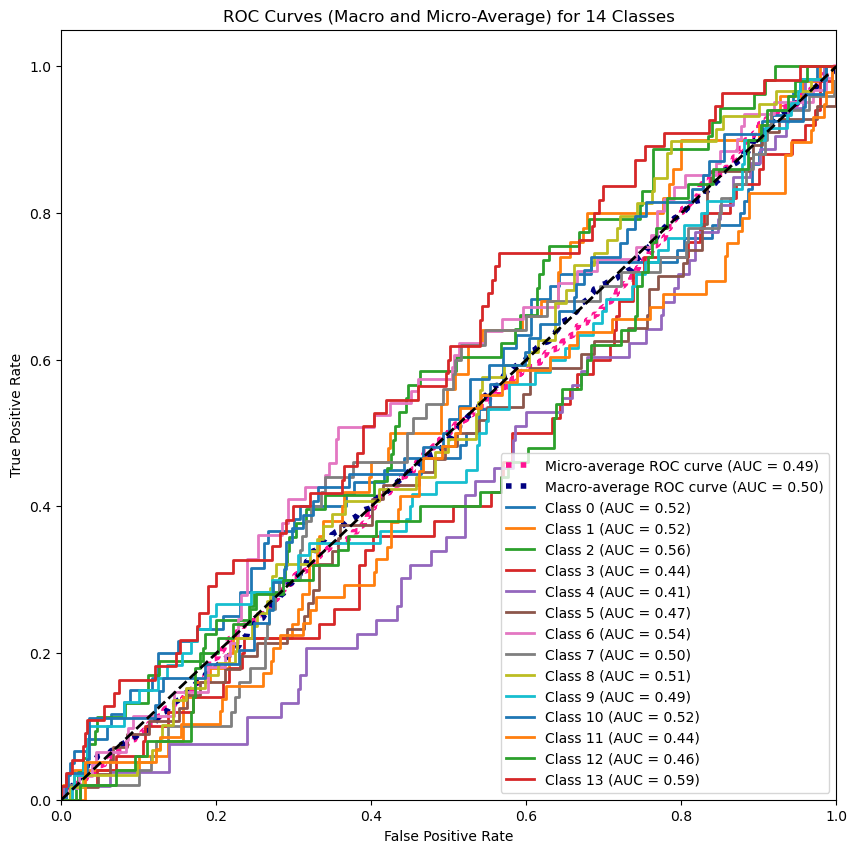

In [64]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming you have y_test (true labels) and y_pred_probs (predicted probabilities)
n_classes = y_test.shape[1]  # Number of classes (14 in your case)

# Binarize the output labels if they aren't already
y_test_binarized = label_binarize(y_test, classes=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"]              = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC AUC
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"]     = all_fpr
tpr["macro"]     = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', color='navy', linestyle=':', linewidth=4)

# Plot ROC curve for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot configuration
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Macro and Micro-Average) for 14 Classes')
plt.legend(loc="lower right")
plt.show()

In [65]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.legend(loc="best")
plt.xlabel("Threshold")
plt.show()

ValueError: multilabel-indicator format is not supported